# Techniki inteligencji obliczeniowej – Multi Layer Perceptron

**Opis danych:** Zbiór danych MNIST zawiera obrazy cyfr odręcznych o rozmiarze 28×28 pikseli, używany do klasyfikacji cyfr od 0 do 9.

**Autorzy:** Adrian Broniecki, Mateusz Gazda

**Implementacja:** 
* Model został zaimplementowany na dwa sposoby: w czystym NumPy oraz przy użyciu biblioteki Keras (TensorFlow).

* Sieć jest typu **Multi Layer Perceptron (MLP)** z co najmniej jedną warstwą ukrytą, które wykorzystują funkcję aktywacji (**ReLU**).

* Wyjście modelu korzysta z funkcji softmax, która w przypadku problemu MNIST, umożliwia klasyfikację wieloklasową.

* Model może być trenowany przy użyciu stochastycznego spadku gradientu (SGD) lub optymalizatora Adam, zaś wagi są inicjalizowane metodą He initialization.

* Zastosowano również normalizację danych oraz opcjonalny dropout dla regularyzacji, aby ograniczyć nadmierne dopasowanie (ang. overfitting) do danych treningowych.


In [ ]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from MLP import NumpyMLP

MODE = 'keras'  # 'Keras' or 'Numpy'

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape)
print(y_train.shape) 

(60000, 28, 28)
(60000,)


In [3]:
print(np.isnan(x_train).any())
print(np.isnan(y_train).any())

False
False


In [4]:
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

In [5]:
def my_to_categorical(y, num_classes=None):
    """
    Convert class vector (integers) to one-hot encoded matrix.
    
    Parameters:
    y : array-like of shape (n_samples,)
        Class labels as integers.
    num_classes : int, optional
        Total number of classes. If None, it is inferred from the data.
    
    Returns:
    onehot : ndarray of shape (n_samples, num_classes)
        One-hot encoded labels as float32.
    """
    y = np.asarray(y)
    if num_classes is None:
        num_classes = np.max(y) + 1

    onehot = np.zeros((y.shape[0], num_classes), dtype=np.float32)

    onehot[np.arange(y.shape[0]), y] = 1.0

    return onehot

In [6]:
y_train = my_to_categorical(y_train, num_classes=10)
y_test = my_to_categorical(y_test, num_classes=10)

In [7]:
x_train, x_val = x_train[:48000], x_train[48000:]
y_train, y_val = y_train[:48000], y_train[48000:]

In [8]:
def create_mlp(input_shape=(784,), 
               hidden_units=[256, 128], 
               activation='relu', 
               dropout_rate=0.3, 
               num_classes=10,
               backend='keras'):
    """
    Create a customizable MLP model with Keras or NumPy backend.

    Parameters:
    -----------
    input_shape : tuple
        Shape of the input vector (default 784 for MNIST flattened).
    hidden_units : list of int
        Number of neurons in each hidden layer (default [256, 128]).
    activation : str
        Activation function for hidden layers (e.g., 'relu', 'tanh', 'sigmoid').
    dropout_rate : float
        Dropout rate applied after each hidden layer (0 = no dropout).
    num_classes : int
        Number of output classes (default 10 for MNIST).
    backend : str
        Backend to use ('keras' or 'numpy').

    Returns:
    --------
    model : tf.keras.Model
        Compiled MLP model ready for training.
    """

    if backend.lower() == 'keras':
        model = Sequential()
        model.add(Dense(hidden_units[0], activation=activation, input_shape=input_shape))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        for units in hidden_units[1:]:
            model.add(Dense(units, activation=activation))
            if dropout_rate > 0:
                model.add(Dropout(dropout_rate))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    elif backend.lower() == 'numpy':
        return NumpyMLP(input_shape=input_shape, hidden_units=hidden_units,
                        activation=activation, dropout_rate=dropout_rate,
                        num_classes=num_classes)
    else:
        raise ValueError("backend must be 'keras' or 'numpy'")

In [9]:
model = create_mlp(hidden_units=[256, 128], activation='relu', dropout_rate=0.3, backend=MODE)

c:\Users\Adrian\Desktop\Magisterka\SEMESTR2\TIO\Labolatorium\TIO\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
def train_model(model, x_train, y_train, x_val, y_val,
                optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'], epochs=15, batch_size=128):
    """
    Train the MLP model. Works for both Keras and NumPy backends.
    Returns trained model and training history.
    """
    if isinstance(model, NumpyMLP):
        history = model.fit(
            X_train=x_train,
            Y_train=y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            metrics=metrics,
            verbose=1
        )
        return model, history
    
    else:
        # Select optimizer
        if optimizer.lower() == 'adam':
            opt = tf.keras.optimizers.Adam()
        elif optimizer.lower() == 'sgd':
            opt = tf.keras.optimizers.SGD()
        else:
            opt = tf.keras.optimizers.get(optimizer)

        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)

        history_obj = model.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1)
        
        history = history_obj.history
        return model, history


In [11]:
def hyperparameter_search(x_train, y_train, x_val, y_val,
                                   hidden_units_list=[[128], [256, 128]],
                                   activations=['relu', 'tanh'],
                                   dropout_rates=[0.0, 0.3, 0.5],
                                   optimizers=['adam', 'sgd'],
                                   losses=['categorical_crossentropy'],
                                   metrics_list=[['accuracy', 'precision', 'recall', 'TopKCategoricalAccuracy']],
                                   epochs=[5, 10, 15, 20],
                                   batch_size=128):
    """
    Test all combinations of hyperparameters and return results DataFrame.
    """
    results = []

    for hidden_units, activation, dropout_rate, optimizer, loss, metrics, epochs_n in itertools.product(
        hidden_units_list, activations, dropout_rates, optimizers, losses, metrics_list, epochs
    ):
        print(f"Testing: hidden_units={hidden_units}, activation={activation}, dropout={dropout_rate}, optimizer={optimizer}, loss={loss}")
        model = create_mlp(hidden_units=hidden_units, activation=activation, dropout_rate=dropout_rate, backend=MODE)
        model, history = train_model(model, x_train, y_train, x_val, y_val,
                                     optimizer=optimizer, loss=loss, metrics=metrics,
                                     epochs=epochs_n, batch_size=batch_size)

        if isinstance(history, dict):
            val_acc = max(history.get('val_accuracy', []))
        else:
            metric_name = metrics[0]  
            val_acc = max(history.history[metric_name])
    
        results.append({
            'hidden_units': hidden_units,
            'activation': activation,
            'dropout_rate': dropout_rate,
            'optimizer': optimizer,
            'loss': loss,
            'metrics': metrics,
            'val_accuracy': val_acc,
            'model': model,
            'history': history
        })

    return pd.DataFrame(results)


# results = hyperparameter_search(
#     x_train, y_train,
#     x_val, y_val,
#     hidden_units_list=[[128], [256,128]],
#     activations=['relu', 'tanh'],
#     dropout_rates=[0.0, 0.3],
#     optimizers=['adam', 'sgd'],
#     losses=['categorical_crossentropy'],
#     metrics_list=[['accuracy'], ['accuracy','TopKCategoricalAccuracy']],
#     epochs=[5, 10, 15, 20]
# )

results = hyperparameter_search(
    x_train, y_train,
    x_val, y_val,
    hidden_units_list=[[256,128]],
    activations=['relu'],
    dropout_rates=[0.3],
    optimizers=['adam'],
    losses=['categorical_crossentropy'],
    metrics_list=[['accuracy', 'precision', 'recall', 'TopKCategoricalAccuracy']],
    epochs=[20]
)

results_sorted = results.sort_values(by='val_accuracy', ascending=False)
print(results_sorted.head(10))

Testing: hidden_units=[256, 128], activation=relu, dropout=0.3, optimizer=adam, loss=categorical_crossentropy
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - TopKCategoricalAccuracy: 0.9850 - accuracy: 0.8709 - loss: 0.4262 - precision: 0.9270 - recall: 0.8165 - val_TopKCategoricalAccuracy: 0.9982 - val_accuracy: 0.9545 - val_loss: 0.1547 - val_precision: 0.9646 - val_recall: 0.9453
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - TopKCategoricalAccuracy: 0.9981 - accuracy: 0.9456 - loss: 0.1798 - precision: 0.9582 - recall: 0.9336 - val_TopKCategoricalAccuracy: 0.9984 - val_accuracy: 0.9660 - val_loss: 0.1133 - val_precision: 0.9716 - val_recall: 0.9602
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - TopKCategoricalAccuracy: 0.9989 - accuracy: 0.9588 - loss: 0.1369 - precision: 0.9671 - recall: 0.9510 - val_TopKCategoricalAccuracy: 0.9989 - val_accuracy: 0.9695 - val_loss: 0.0987 - val_precision: 0.9751 - val_recall: 0.9654
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3

In [12]:
def plot_learning_curves(history):
    """
    Plot train and validation accuracy/loss curves from history.
    Works for both Keras History object and dict (NumPyMLP).
    """
    if hasattr(history, 'history'):
        hist = history.history
    else:
        hist = history
    
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist['accuracy'], label='Train')
    plt.plot(hist.get('val_accuracy', []), label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    if 'loss' in hist:
        plt.plot(hist['loss'], label='Train')
        plt.plot(hist.get('val_loss', []), label='Validation')
    else:
        plt.plot([None]*len(hist['accuracy']), label='Train')
        plt.plot([None]*len(hist.get('val_accuracy', [])), label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

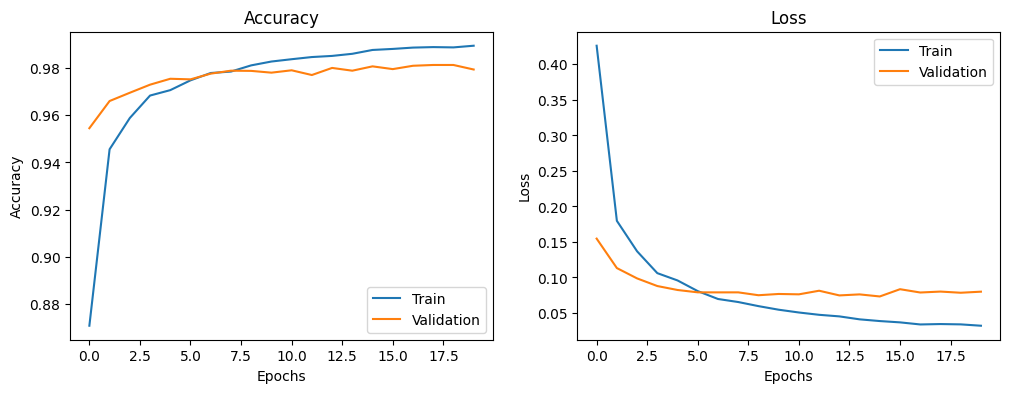

In [13]:
best_row = results_sorted.iloc[0]
best_model = best_row['model']
best_history = best_row['history']

plot_learning_curves(best_history)

In [14]:
def evaluate_model(model, x_test, y_test, top_n_wrong=10):
    if isinstance(model, NumpyMLP):
        test_loss, test_acc = model.evaluate(x_test, y_test)
        results_dict = {'loss': test_loss, 'accuracy': test_acc}
    else:
        results = model.evaluate(x_test, y_test, verbose=0)
        metric_names = model.metrics_names
        results_dict = dict(zip(metric_names, results))
        test_loss = results_dict.get('loss')
        test_acc = results_dict.get('accuracy') or results_dict.get('acc')

    print("Evaluation results:")
    for k, v in results_dict.items():
        if v is not None:
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: None")

    y_pred_probs = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    wrong = np.where(y_pred_labels != y_true_labels)[0]
    print(f"Number of misclassified examples: {len(wrong)}")

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(wrong[:top_n_wrong]):
        plt.subplot(2, top_n_wrong//2, i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.title(f"True:{y_true_labels[idx]}, Pred:{y_pred_labels[idx]}")
        plt.axis('off')
    plt.show()


In [15]:
print(best_model)

<Sequential name=sequential_1, built=True>


Evaluation results:
loss: 0.0706
compile_metrics: 0.9832
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of misclassified examples: 168


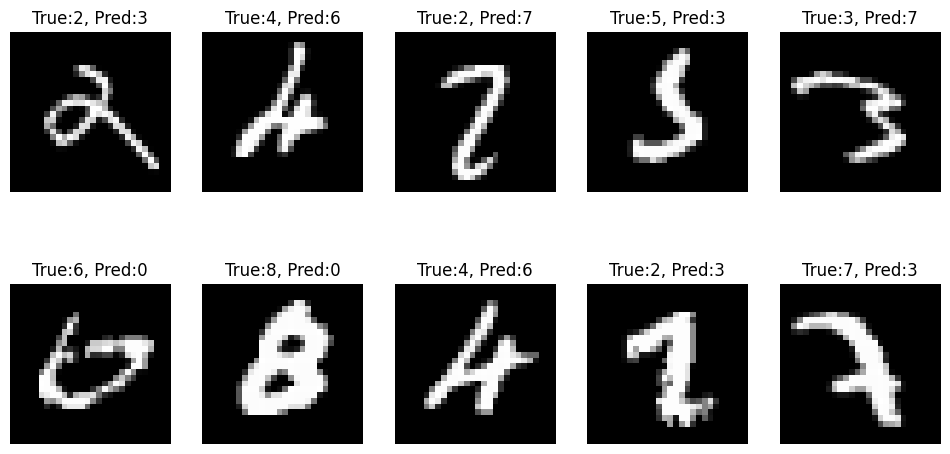

In [16]:
evaluate_model(best_model, x_test, y_test)